# Item-Based Collaborative Filtering

In [1]:
# Import all the necessary packages
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Step 1: Reading the Data
#### [MovieLens 100K Dataset](https://grouplens.org/datasets/movielens/) is already split for us into 80% training, 20% testing.

In [2]:
train_df = pd.read_csv('ml-100k\\u1.base', sep="\t", names=["userId", "movieId", "rating", "time"])
test_df = pd.read_csv('ml-100k\\u1.test', sep="\t", names=["userId", "movieId", "rating", "time"])

In [3]:
train_df.head()

,userId,movieId,rating,time
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [4]:
test_df.head()

,userId,movieId,rating,time
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


# Step 2: Normalizing the Data

In [5]:
# Normalize the ratings by subtracting the average rating of each user from their rating

# First we find the average rating of each user
train_df.loc[:,'Avg Rating'] = train_df['userId'].map(train_df.groupby('userId')['rating'].mean())

# Then we subtract their average rating from each of their ratings
train_df.loc[:,'Norm Rating'] = train_df['rating'] - train_df['Avg Rating']

In [6]:
train_df.head()

,userId,movieId,rating,time,Avg Rating,Norm Rating
0,1,1,5,874965758,3.681481,1.318519
1,1,2,3,876893171,3.681481,-0.681481
2,1,3,4,878542960,3.681481,0.318519
3,1,4,3,876893119,3.681481,-0.681481
4,1,5,3,889751712,3.681481,-0.681481


# Step 3: Creating User-Item Utility Matrices

In [7]:
# Create a ratings-based utility matrix with original rating values which will be used to predict the ratings later on
user_item_matrix = train_df.pivot_table(index='userId', columns='movieId',values='rating')

# Create a ratings-based utility matrix with the normalized rating values which will be used to calculate the cosine similarity.
normalized_user_item_matrix = train_df.pivot_table(index='userId', columns='movieId',values='Norm Rating')

In [8]:
normalized_user_item_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,
1,1.318519,-0.681481,0.318519,-0.681481,-0.681481,NaN,0.318519,-2.681481,1.318519,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 4: Finding Cosine Similarity Between All Pairs of Items

In [9]:
# Creating a dictionary to store similarities
sim_dict = {}

# For this demonstration, a target user is chosen. 
# First, create a subset of items rated by target user
# Items that are not rated aren't included
target_user = 2
target_user_items = normalized_user_item_matrix.loc[[target_user]].dropna(axis='columns')

# item1 and item2 are vectors 
# Cosine similarity is used to calculate the angle between the two vectors
# Because we dropped rows that contain 'NaN', each series might be empty
# In the case that the vectors are empty, we return -1 to signify the two vectors have no observed ratings in common
# Otherwise, we calculate the cosine similarity of the two vectors
def cos_sim(item1, item2):
    if item1.empty or item2.empty:
        return -1
    
    result = (item1*item2).sum() / (math.sqrt((item1**2).sum()) * math.sqrt((item2**2).sum()))
    return round(result,2)

for item1 in target_user_items:
    np.warnings.filterwarnings('ignore')
    for item2 in normalized_user_item_matrix:
        if (item1,item2) in sim_dict or (item2,item1) in sim_dict or item1 == item2:
            continue
        common_ratings_df = normalized_user_item_matrix[[item1,item2]].dropna()
        sim_dict[(item1,item2)] = cos_sim(common_ratings_df[item1],common_ratings_df[item2])

# Step 5: Predict Ratings

In [10]:
# This function will find the k closest neighbors of the parameter itemID
# It returns the top k most similar items using the item-item similarity dictionary created earlier
def kNeighbors(itemID, simDict, k):
    lst = []
    for key in simDict:
        if itemID in key:
            lst.append((key,simDict[key])) 
    sortedList = sorted(lst, key = lambda x: float(x[1]), reverse = True)
    return sortedList[:k]

# This function returns the predicted rating of the itemId for 
# userId by calculating the sum of the ratings given by the userId
# on the k most similar items
def weightedSum(userId, itemId, k, closeset_k_neighbors_dict):
    total1 = 0
    total2 = 0
    for key in closeset_k_neighbors_dict.keys():
        for i in key:
            if i != itemId:
                total1 += closeset_k_neighbors_dict[key] * user_item_matrix.at[userId,i]
                total2 += abs(closeset_k_neighbors_dict[key])
    
    return round((total1/total2),2)

# k is the number of neighbors
k = 20

dataTest= test_df[test_df['userId'] == target_user]
dataTest=dataTest.set_index(pd.Series(range(dataTest.shape[0])))
predictedRatings = []

for i in range(0, len(dataTest)):
    closeset_k_neighbors_lst = kNeighbors(dataTest["movieId"][i], sim_dict, k)
    closeset_k_neighbors_dict = dict(closeset_k_neighbors_lst)
    predictedRatings.append(weightedSum(target_user,dataTest["movieId"][i],k,closeset_k_neighbors_dict))

dataTest['predictedRating'] = predictedRatings

In [11]:
dataTest.head()

,userId,movieId,rating,time,predictedRating
0,2,13,4,888551922,3.35
1,2,19,3,888550871,4.38
2,2,50,5,888552084,4.25
3,2,251,5,888552084,4.21
4,2,257,4,888551062,3.29


# Step 6: Calculate the Mean Absolute Error

In [12]:
N = len(dataTest)
difference = abs(dataTest["rating"] - dataTest["predictedRating"])
result = difference.sum()
mean_absolute_error = round(result/N, 2)

print("The mean absolute error =", mean_absolute_error)

The mean absolute error = 0.97


# Step 7: Results

The item-based similarity model was tested by finding the predicted rating
for k = 1,5,10,15,20,and 50 neighbors and then calculating the mean absolute errors for each k
value. The errors are plotted as a curve shown below. At first, you see the MAE decreasing as
the value of k increases. Then at around k=20, the MAE appears to be going back up. I found that 
the sweet spot is around k=15 since it produced the lowest MAE.

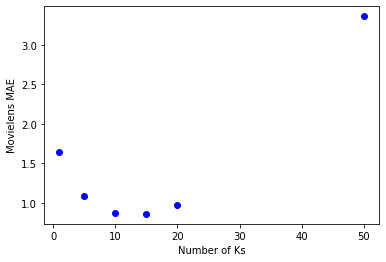

In [13]:
k_values=[1,5,10,15,20,50]
mae_results =[1.64,1.09,0.87,0.86,0.97,3.36]


plt.plot(k_values,mae_results, "bo")
plt.ylabel("Movielens MAE")
plt.xlabel("Number of Ks")
plt.show()